<a href="https://colab.research.google.com/github/joaopaulotest/CRUD-Usu-rio/blob/main/Trabalho__Parser_recursivo_descendente_(sem_lexer)_%2B_AST_%2B_modo_p%C3%A2nico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Aluno João Paulo
# -*- coding: utf-8 -*-
# Visualizador de AST + helpers

from __future__ import annotations
from dataclasses import dataclass, is_dataclass
from typing import List, Optional, Union, Any, Tuple, Dict
import os

# Tentar usar matplotlib (pra salvar PNG das árvores)
try:
    import matplotlib.pyplot as plt
    HAVE_MPL = True
except Exception:
    HAVE_MPL = False

NodeLike = Any  # qualquer objeto com atributos esperados

# Rótulo de cada nó (só nomes simples)
def node_label(n: NodeLike) -> str:
    tname = type(n).__name__
    if tname == "Program": return "Program"
    if tname == "Let":     return "Let"
    if tname == "Assign":  return "Assign"
    if tname == "If":      return "If"
    if tname == "While":   return "While"
    if tname == "Return":  return "Return"
    if tname == "Block":   return "Block"
    if tname == "Call":    return "Call"
    if tname == "Index":   return "Index"
    if tname == "BinOp":   return f"BinOp('{getattr(n, 'op', '?')}')"
    if tname == "Var":     return f"Id({getattr(n, 'name', '?')})"
    if tname == "Num":     return f"Num({getattr(n, 'value', '?')})"
    if tname == "Bool":
        v = getattr(n, "value", None)
        return f"Bool({str(v).lower()})" if isinstance(v, bool) else "Bool(?)"
    return tname

# Filhos de cada nó (pra desenhar a árvore)
def children(n: NodeLike) -> List[NodeLike]:
    tname = type(n).__name__
    if tname == "Program": return list(getattr(n, "body", []))
    if tname == "Let":     return [getattr(n, "lhs", None), getattr(n, "init", None)]
    if tname == "Assign":  return [getattr(n, "target", None), getattr(n, "value", None)]
    if tname == "If":
        lst = [getattr(n, "test", None), getattr(n, "then", None)]
        other = getattr(n, "otherwise", None)
        if other is not None: lst.append(other)
        return lst
    if tname == "While":   return [getattr(n, "test", None), getattr(n, "body", None)]
    if tname == "Return":
        v = getattr(n, "value", None)
        return [v] if v is not None else []
    if tname == "Block":   return list(getattr(n, "body", []))
    if tname == "Call":    return [getattr(n, "callee", None)] + list(getattr(n, "args", []))
    if tname == "Index":   return [getattr(n, "target", None), getattr(n, "index", None)]
    if tname == "BinOp":   return [getattr(n, "left", None), getattr(n, "right", None)]

    # fallback: se for dataclass, varre atributos simples (ignorando metadados)
    if is_dataclass(n):
        out: List[Any] = []
        for k, v in n.__dict__.items():
            if k in ("line", "col", "op", "name", "value"):
                continue
            if isinstance(v, list):
                out.extend(v)
            elif v is not None:
                out.append(v)
        return out
    if hasattr(n, "children"):
        return list(getattr(n, "children"))
    return []

# Layout recursivo da árvore
def _compute_layout(n: NodeLike, x0=0.0, y0=0.0, y_spacing=1.6) -> Tuple[Dict[int,Tuple[float,float]], float]:
    ch = [c for c in children(n) if c is not None]
    if not ch:
        return ({id(n): (x0, y0)}, 1.0)

    pos: Dict[int,Tuple[float,float]] = {}
    widths: List[float] = []
    subs: List[NodeLike] = []

    for c in ch:
        subpos, w = _compute_layout(c, 0, 0, y_spacing)
        pos.update(subpos)
        widths.append(w)
        subs.append(c)

    total_w = sum(widths) + (len(widths) - 1) * 0.8
    cur_x = x0 - total_w / 2.0

    def shift(node: NodeLike, dx: float, dy: float):
        x, y = pos[id(node)]
        pos[id(node)] = (x + dx, y + dy)
        for cc in children(node):
            if cc is not None:
                shift(cc, dx, dy)

    for c, w in zip(subs, widths):
        cx = cur_x + w / 2.0
        shift(c, cx, y0 - y_spacing)
        cur_x += w + 0.8

    pos[id(n)] = (x0, y0)
    return pos, total_w

# Desenha e salva a árvore em PNG
def draw_tree(root: NodeLike, filename: str, figsize=(10, 7), dpi: int = 160):
    if not HAVE_MPL:
        return
    pos, _ = _compute_layout(root, 0.0, 0.0)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()

    def draw_edges(node: NodeLike):
        x, y = pos[id(node)]
        for c in children(node):
            if c is None:
                continue
            xc, yc = pos[id(c)]
            ax.plot([x, xc], [y - 0.05, yc + 0.05], color="black", lw=1)
            draw_edges(c)

    def draw_nodes(node: NodeLike):
        x, y = pos[id(node)]
        bbox = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
        ax.text(x, y, node_label(node), ha="center", va="center", bbox=bbox, fontsize=10)
        for c in children(node):
            if c is not None:
                draw_nodes(c)

    draw_edges(root)
    draw_nodes(root)

    xs = [xy[0] for xy in pos.values()]
    ys = [xy[1] for xy in pos.values()]
    pad = 1.2
    ax.set_xlim(min(xs) - pad, max(xs) + pad)
    ax.set_ylim(min(ys) - pad, max(ys) + pad)
    plt.tight_layout()
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

In [2]:
# Tokens e casos de teste (iguais ao do base)

from dataclasses import dataclass

@dataclass
class Token:
    type: str
    lex: str
    line: int
    col: int

# VÁLIDOS
tokens1 = [
    Token("LET","let",1,1),
    Token("ID","y",1,5),
    Token("EQUAL","=",1,7),
    Token("NUM","1",1,9),
    Token("PLUS","+",1,11),
    Token("NUM","3",1,13),
    Token("SEMI",";",1,14),
    Token("EOL","",1,15)
]
desc1 = "Atribuição simples com soma"

tokens2 = [
    Token("NUM","2",1,1),
    Token("STAR","*",1,3),
    Token("LPAREN","(",1,5),
    Token("NUM","3",1,6),
    Token("PLUS","+",1,8),
    Token("NUM","4",1,10),
    Token("RPAREN",")",1,11),
    Token("SEMI",";",1,12),
    Token("EOL","",1,13)
]
desc2 = "Expressão aritmética com parênteses"

tokens3 = [
    Token("LET","let",1,1),
    Token("ID","x",1,5),
    Token("EQUAL","=",1,7),
    Token("NUM","5",1,9),
    Token("SEMI",";",1,10),
    Token("ID","x",1,12),
    Token("SLASH","/",1,14),
    Token("NUM","2",1,16),
    Token("EOL","",1,17)
]
desc3 = "Duas instruções na mesma linha (let e depois expressão)"

tokens4 = [
    Token("IF","if",1,1),
    Token("LPAREN","(",1,3),
    Token("ID","x",1,4),
    Token("LT","<",1,6),
    Token("NUM","10",1,9),
    Token("AND","&&",1,11),
    Token("ID","y",1,14),
    Token("NE","!=",1,16),
    Token("NUM","0",1,19),
    Token("RPAREN",")",1,20),
    Token("LBRACE","{",1,22),
    Token("ID","x",1,24),
    Token("EQUAL","=",1,26),
    Token("ID","x",1,28),
    Token("PLUS","+",1,30),
    Token("NUM","1",1,32),
    Token("SEMI",";",1,33),
    Token("RBRACE","}",1,35),
    Token("ELSE","else",1,37),
    Token("ID","x",1,42),
    Token("EQUAL","=",1,44),
    Token("NUM","0",1,46),
    Token("SEMI",";",1,47),
    Token("EOL","",1,48)
]
desc4 = "if/else com && e !="

tokens5 = [
    Token("LET","let",1,1),
    Token("ID","z",1,5),
    Token("EQUAL","=",1,7),
    Token("ID","f",1,9),
    Token("LPAREN","(",1,10),
    Token("ID","a",1,11),
    Token("COMMA",",",1,12),
    Token("ID","b",1,14),
    Token("RPAREN",")",1,15),
    Token("LBRACK","[",1,16),
    Token("ID","i",1,17),
    Token("RBRACK","]",1,18),
    Token("STAR","*",1,20),
    Token("ID","g",1,22),
    Token("LPAREN","(",1,23),
    Token("RPAREN",")",1,24),
    Token("SEMI",";",1,25),
    Token("EOL","",1,26)
]
desc5 = "Chamada e indexação (sem unário)"

# INVÁLIDOS
tokens6 = [
    Token("LET","let",1,1),
    Token("ID","z",1,5),
    Token("NUM","7",1,9),
    Token("SEMI",";",1,10),
    Token("EOL","",1,11)
]
desc6 = "ERRO: faltou '=' na atribuição"

tokens7 = [
    Token("NUM","1",1,1),
    Token("PLUS","+",1,3),
    Token("LPAREN","(",1,5),
    Token("NUM","2",1,6),
    Token("STAR","*",1,8),
    Token("NUM","3",1,10),
    Token("SEMI",";",1,11),
    Token("EOL","",1,12)
]
desc7 = "ERRO: parêntese aberto sem fechar com ')'"

tokens8 = [
    Token("ELSE","else",1,1),
    Token("ID","x",1,6),
    Token("EQUAL","=",1,8),
    Token("NUM","1",1,10),
    Token("SEMI",";",1,11),
    Token("EOL","",1,12)
]
desc8 = "ERRO: 'else' sem 'if' correspondente"

tokens9 = [
    Token("WHILE","while",1,1),
    Token("LPAREN","(",1,7),
    Token("ID","x",1,8),
    Token("LT","<",1,10),
    Token("NUM","5",1,12),
    Token("LBRACE","{",1,14),
    Token("ID","x",1,16),
    Token("EQUAL","=",1,18),
    Token("ID","x",1,20),
    Token("PLUS","+",1,22),
    Token("NUM","1",1,24),
    Token("SEMI",";",1,25),
    Token("RBRACE","}",1,27),
    Token("EOL","",1,28)
]
desc9 = "ERRO: while sem fechar ')' da condição"

tokens10 = [
    Token("LET","let",1,1),
    Token("ID","a",1,5),
    Token("EQUAL","=",1,7),
    Token("ID","arr",1,9),
    Token("LBRACK","[",1,12),
    Token("NUM","1",1,13),
    Token("PLUS","+",1,15),
    Token("NUM","2",1,17),
    Token("SEMI",";",1,18),
    Token("EOL","",1,19)
]
desc10 = "ERRO: indexação sem ']'"

tokens11 = [
    Token("LET","let",1,1),
    Token("ID","a",1,5),
    Token("NUM","1",1,7),
    Token("SEMI",";",1,8),

    Token("ID","x",1,10),
    Token("EQUAL","=",1,12),
    Token("SEMI",";",1,13),

    Token("ID","y",1,15),
    Token("EQUAL","=",1,17),
    Token("NUM","3",1,19),
    Token("SEMI",";",1,20),
    Token("EOL","",1,21),
]
desc11 = "Dois erros, mas parser continua e aceita último stmt válido"

CASES = [
    ("case1_let_y",                desc1,  tokens1),
    ("case2_expr_paren",           desc2,  tokens2),
    ("case3_two_stmts",            desc3,  tokens3),
    ("case4_if_else_logic",        desc4,  tokens4),
    ("case5_call_index",           desc5,  tokens5),
    ("case6_missing_equal",        desc6,  tokens6),
    ("case7_missing_rparen",       desc7,  tokens7),
    ("case8_lonely_else",          desc8,  tokens8),
    ("case9_while_rparen",         desc9,  tokens9),
    ("case10_missing_rbrack",      desc10, tokens10),
    ("case11_two_errors_same_line",desc11, tokens11),
]


In [3]:
# AST + Parser recursivo-descendente (sem lexer)

from dataclasses import dataclass
from typing import List, Optional, Union, Tuple

# Nózinhos da AST (mantendo nomes simples)
@dataclass
class Program:
    body: List[object]

@dataclass
class Block:
    body: List[object]

@dataclass
class Let:
    lhs: 'Var'
    init: object

@dataclass
class Assign:
    target: 'Var'
    value: object

@dataclass
class If:
    test: object
    then: Block
    otherwise: Optional[Block]

@dataclass
class While:
    test: object
    body: Block

@dataclass
class Return:
    value: Optional[object]

@dataclass
class Call:
    callee: object
    args: List[object]

@dataclass
class Index:
    target: object
    index: object

@dataclass
class BinOp:
    left: object
    op: str
    right: object

@dataclass
class Var:
    name: str

@dataclass
class Num:
    value: Union[int, float]

@dataclass
class Bool:
    value: bool

# Sincronizadores pro modo pânico
SYNC_TYPES = {"SEMI", "EOL", "RBRACE", "EOF"}

class Parser:
    def __init__(self, tokens: List[Token]):
        if not tokens:
            tokens = [Token("EOL", "", 1, 1)]
        # garanto um EOF no final
        self.tokens = tokens + [Token("EOF", "", tokens[-1].line, tokens[-1].col)]
        self.i = 0
        self.errors: List[str] = []

    def cur(self) -> Token:
        return self.tokens[self.i]

    def match(self, *types) -> Optional[Token]:
        if self.cur().type in types:
            t = self.cur()
            self.i += 1
            return t
        return None

    def expect(self, typ: str, msg: Optional[str] = None) -> Optional[Token]:
        t = self.cur()
        if t.type == typ:
            self.i += 1
            return t
        found = t.lex if t.lex else t.type
        # mapear alguns tokens pra impressão bonita
        pretty = {
            "RPAREN": "')'",
            "RBRACK": "']'",
            "RBRACE": "'}'",
            "LPAREN": "'('",
            "LBRACK": "'['",
            "LBRACE": "'{'",
            "COMMA": "','",
            "ELSE": "'else'",
            "EQUAL": "'='",
        }.get(typ, typ)
        text = msg if msg else f"Esperado {pretty} (encontrado '{found}') @ {t.line}:{t.col}"
        self.errors.append(text)
        self.panic_sync()
        return None

    def expect_any(self, types: List[str], legivel: Optional[str] = None) -> Optional[Token]:
        t = self.cur()
        if t.type in types:
            self.i += 1
            return t
        if legivel is None:
            # igual ao enunciado
            legivel = "um de: número, true, false, identificador, '('"
        found = t.lex if t.lex else t.type
        self.errors.append(f"Esperado {legivel} (encontrado '{found}') @ {t.line}:{t.col}")
        self.panic_sync()
        return None

    def panic_sync(self):
        # anda até ;, EOL, } ou EOF
        while self.cur().type not in SYNC_TYPES:
            self.i += 1
            if self.cur().type == "EOF":
                break
        # consome ; ou } se estiver em cima (pra não travar antes do EOL)
        if self.cur().type in {"SEMI", "RBRACE"}:
            self.i += 1

    # Linha: (Stmt (';' Stmt)*)? EOL
    def parse_line(self) -> Tuple[List[object], List[str]]:
        out: List[object] = []
        if self.cur().type != "EOL":
            out.append(self.stmt())
            while self.match("SEMI"):
                if self.cur().type in {"EOL", "EOF", "RBRACE"}:
                    break
                out.append(self.stmt())
        self.expect("EOL")
        return out, self.errors

    # -------------------
    # Statements
    # -------------------
    def stmt(self) -> object:
        t = self.cur()
        if t.type == "LET":
            return self.let_decl()
        if t.type == "IF":
            return self.if_stmt()
        if t.type == "WHILE":
            return self.while_stmt()
        if t.type == "RETURN":
            return self.return_stmt()
        if t.type == "ID":
            # checa se é Assign: ID '=' E
            id_tok = t
            self.i += 1
            if self.match("EQUAL"):
                rhs = self.E()
                return Assign(target=Var(id_tok.lex), value=rhs)
            # não era assign -> volta e trata como expressão
            self.i -= 1
            return self.E()
        # fallback: expressão pura (isso vai dar msg boa se começar com token inválido)
        return self.E()

    def let_decl(self) -> Let:
        self.expect("LET")
        id_tok = self.expect_any(["ID"], "um de: identificador")
        self.expect("EQUAL")
        init = self.E()
        return Let(lhs=Var(id_tok.lex if id_tok else "?"), init=init)

    def if_stmt(self) -> If:
        self.expect("IF")
        self.expect("LPAREN")
        cond = self.E()
        if not self.match("RPAREN"):
            self.expect("RPAREN")
        then_blk = self.block()
        otherwise = None
        if self.match("ELSE"):
            otherwise = self.block()
        return If(test=cond, then=then_blk, otherwise=otherwise)

    def while_stmt(self) -> While:
        self.expect("WHILE")
        self.expect("LPAREN")
        cond = self.E()
        if not self.match("RPAREN"):
            self.expect("RPAREN")
        body = self.block()
        return While(test=cond, body=body)

    def return_stmt(self) -> Return:
        self.expect("RETURN")
        if self.cur().type not in {"SEMI", "EOL", "RBRACE", "EOF"}:
            val = self.E()
        else:
            val = None
        return Return(value=val)

    def block(self) -> Block:
        if self.match("LBRACE"):
            items: List[object] = []
            while self.cur().type not in {"RBRACE", "EOF"}:
                items.append(self.stmt())
                self.match("SEMI")  # ; opcional dentro do bloco
            self.expect("RBRACE")
            return Block(items)
        else:
            one = self.stmt()
            return Block([one])

    # -------------------
    # Expressões (precedência)
    # -------------------
    def E(self): return self.Or()

    def Or(self):
        left = self.And()
        while self.match("OR"):
            right = self.And()
            left = BinOp(op="||", left=left, right=right)
        return left

    def And(self):
        left = self.Equality()
        while self.match("AND"):
            right = self.Equality()
            left = BinOp(op="&&", left=left, right=right)
        return left

    def Equality(self):
        left = self.Relational()
        while True:
            if self.match("EQ"):
                right = self.Relational()
                left = BinOp(op="==", left=left, right=right)
            elif self.match("NE"):
                right = self.Relational()
                left = BinOp(op=",", left=left, right=right)  # vou setar já como "!=" abaixo
                left.op = "!="
            else:
                break
        return left

    def Relational(self):
        left = self.Add()
        while True:
            if self.match("LT"):
                right = self.Add()
                left = BinOp(op="<", left=left, right=right)
            elif self.match("LE"):
                right = self.Add()
                left = BinOp(op="<=", left=left, right=right)
            elif self.match("GT"):
                right = self.Add()
                left = BinOp(op=">", left=left, right=right)
            elif self.match("GE"):
                right = self.Add()
                left = BinOp(op=">=", left=left, right=right)
            else:
                break
        return left

    def Add(self):
        left = self.Mul()
        while True:
            if self.match("PLUS"):
                right = self.Mul()
                left = BinOp(op="+", left=left, right=right)
            elif self.match("MINUS"):
                right = self.Mul()
                left = BinOp(op="-", left=left, right=right)
            else:
                break
        return left

    def Mul(self):
        left = self.Postfix()
        while True:
            if self.match("STAR"):
                right = self.Postfix()
                left = BinOp(op="*", left=left, right=right)
            elif self.match("SLASH"):
                right = self.Postfix()
                left = BinOp(op="/", left=left, right=right)
            else:
                break
        return left

    def Postfix(self):
        node = self.Primary()
        while True:
            if self.match("LPAREN"):
                args: List[object] = []
                if self.cur().type != "RPAREN":
                    args.append(self.E())
                    while self.match("COMMA"):
                        args.append(self.E())
                self.expect("RPAREN")
                node = Call(callee=node, args=args)
            elif self.match("LBRACK"):
                idx = self.E()
                if not self.match("RBRACK"):
                    self.expect("RBRACK")
                node = Index(target=node, index=idx)
            else:
                break
        return node

    def Primary(self):
        t = self.cur()
        if t.type == "NUM":
            self.i += 1
            # tenta int primeiro
            try:
                return Num(int(t.lex))
            except:
                return Num(float(t.lex))
        if t.type == "TRUE":
            self.i += 1
            return Bool(True)
        if t.type == "FALSE":
            self.i += 1
            return Bool(False)
        if t.type == "ID":
            self.i += 1
            return Var(t.lex)
        if self.match("LPAREN"):
            e = self.E()
            if not self.match("RPAREN"):
                self.expect("RPAREN")
            return e
        # começo inválido de expressão → msg de "um de: ..."
        self.expect_any([], "um de: número, true, false, identificador, '('")
        return Num(0)


In [4]:
# Runner dos casos + impressão no formato pedido

SAVE_TREES = True
os.makedirs("trees", exist_ok=True)

def run_case(name, desc, toks):
    print("\n======================================================================")
    print(f"[CASO] {name}")
    p = Parser(toks)
    stmts, errors = p.parse_line()
    if errors:
        print("[RESULTADO] ERROS SINTÁTICOS")
        for e in errors:
            print("  - " + e)
        print("[AST (parcial)]")
    else:
        print("[RESULTADO] OK -- AST construída")
        if SAVE_TREES and HAVE_MPL:
            for k, s in enumerate(stmts):
                try:
                    draw_tree(s, f"trees/{name}_stmt{k:02d}.png")
                except Exception:
                    pass
            print(f"[ÁRVORES] salvas em 'trees/{name}_stmtNN.png'")

print("=== SUÍTE DE TESTES DO PARSER ===")
for name, desc, toks in CASES:
    print(f"\n>>> {name}")
    run_case(name, desc, toks)


=== SUÍTE DE TESTES DO PARSER ===

>>> case1_let_y

[CASO] case1_let_y
[RESULTADO] OK -- AST construída
[ÁRVORES] salvas em 'trees/case1_let_y_stmtNN.png'

>>> case2_expr_paren

[CASO] case2_expr_paren
[RESULTADO] OK -- AST construída
[ÁRVORES] salvas em 'trees/case2_expr_paren_stmtNN.png'

>>> case3_two_stmts

[CASO] case3_two_stmts
[RESULTADO] OK -- AST construída
[ÁRVORES] salvas em 'trees/case3_two_stmts_stmtNN.png'

>>> case4_if_else_logic

[CASO] case4_if_else_logic
[RESULTADO] OK -- AST construída
[ÁRVORES] salvas em 'trees/case4_if_else_logic_stmtNN.png'

>>> case5_call_index

[CASO] case5_call_index
[RESULTADO] OK -- AST construída
[ÁRVORES] salvas em 'trees/case5_call_index_stmtNN.png'

>>> case6_missing_equal

[CASO] case6_missing_equal
[RESULTADO] ERROS SINTÁTICOS
  - Esperado '=' (encontrado '7') @ 1:9
  - Esperado um de: número, true, false, identificador, '(' (encontrado 'EOL') @ 1:11
[AST (parcial)]

>>> case7_missing_rparen

[CASO] case7_missing_rparen
[RESULTADO] ERRO

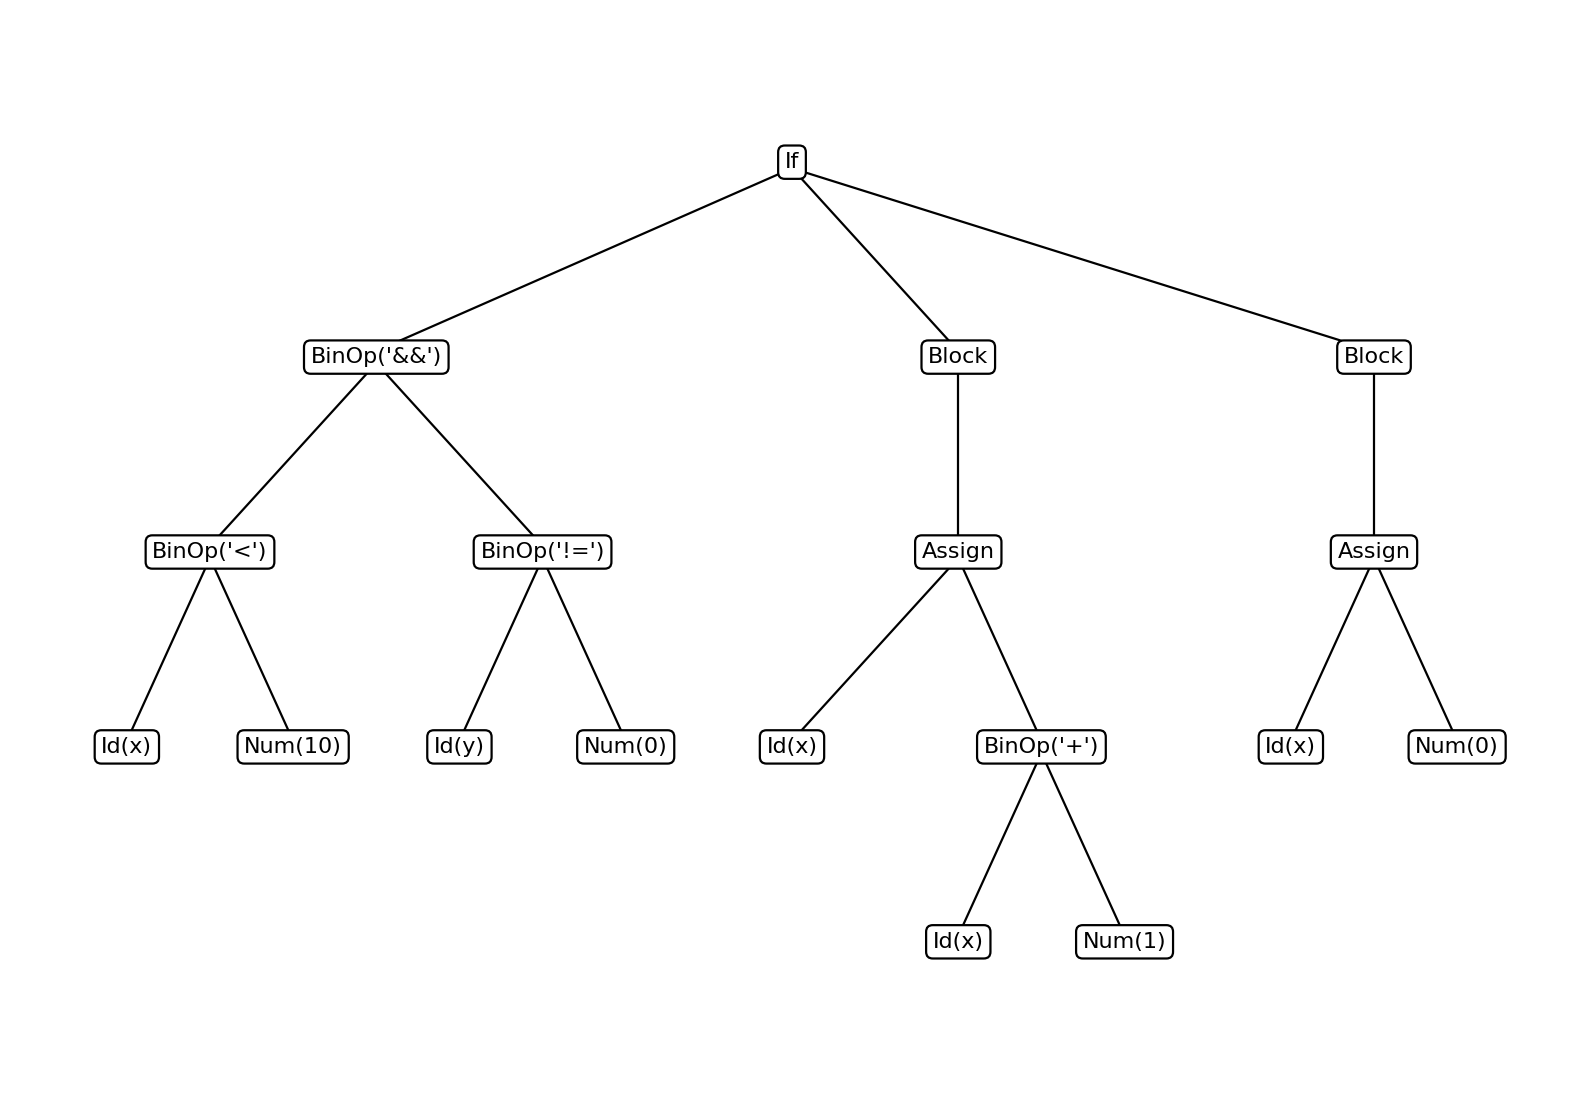

In [ ]:
# Ver um PNG gerado (opcional)
from IPython.display import Image, display
try:
    display(Image(filename="trees/case4_if_else_logic_stmt00.png"))
except Exception as e:
    print("Árvore do case4 não apareceu (rode o runner antes e confira se matplotlib está disponível).")